实现函数来方便下载数据

In [1]:
import hashlib, os, tarfile, zipfile, requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


def download(name, cache_dir=os.path.join('.', 'data')):
    """下载DATAHUB中的文件，并返回本地文件名"""
    assert name in DATA_HUB, f"{name}不存在于DATA_HUB"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            print("本地已经存在")
            return fname  # 本地命中
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    print("下载完成")
    return fname


def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, "只有zip或者tar，gz文件可以被解压"
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():
    for name in DATA_HUB:
        download(name)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import d2l
import lmy

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 使用pandas分别加载训练和测试数据

In [3]:
train_data = pd.read_csv(download('kaggle_house_train'))
# lmy.print_shape(train_data) #1460 x (80 + 1) 1460个数据 80个特征  一个标签（房价)
test_data = pd.read_csv(download('kaggle_house_test'))
# lmy.print_shape(test_data) # 1459 x (80 + 1)


本地已经存在
本地已经存在


In [4]:
# 查看部分数据的特征和标签
print(train_data.iloc[:4, [0, 1, 2, 3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleCondition  SalePrice
0   1          60       RL         65.0        Normal     208500
1   2          20       RL         80.0        Normal     181500
2   3          60       RL         68.0        Normal     223500
3   4          70       RL         60.0       Abnorml     140000


### 可以看到每个样本的第一个特征是ID，这个对于训练毫无意义 所以将其删除

In [5]:
train_features = train_data.iloc[:, 1:-1]
train_labels = train_data.iloc[:, -1]
print(train_features.iloc[:4, [0, 1, 2, 3, -2, -1]])
print(train_labels[:4])

   MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition
0          60       RL         65.0     8450       WD        Normal
1          20       RL         80.0     9600       WD        Normal
2          60       RL         68.0    11250       WD        Normal
3          70       RL         60.0     9550       WD       Abnorml
0    208500
1    181500
2    223500
3    140000
Name: SalePrice, dtype: int64


In [6]:
test_features = test_data.iloc[:, 1:]
print(test_features.iloc[:4, [0, 1, 2, 3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition
0          20       RH         80.0    11622       WD        Normal
1          20       RL         81.0    14267       WD        Normal
2          60       RL         74.0    13830       WD        Normal
3          60       RL         78.0     9978       WD        Normal


In [7]:
all_features = pd.concat((train_features,test_features))
del train_features
del test_features
lmy.print_shape(all_features)

ic| X:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
       0             60       RL         65.0     8450   Pave   NaN      Reg   
       1             20       RL         80.0     9600   Pave   NaN      Reg   
       2             60       RL         68.0    11250   Pave   NaN      IR1   
       3             70       RL         60.0     9550   Pave   NaN      IR1   
       4             60       RL         84.0    14260   Pave   NaN      IR1   
       ...          ...      ...          ...      ...    ...   ...      ...   
       1454         160       RM         21.0     1936   Pave   NaN      Reg   
       1455         160       RM         21.0     1894   Pave   NaN      Reg   
       1456          20       RL        160.0    20000   Pave   NaN      Reg   
       1457          85       RL         62.0    10441   Pave   NaN      Reg   
       1458          60       RL         74.0     9627   Pave   NaN      Reg   
       
            LandContour Utilitie

shape = (2919, 79)
********************


## 数据预处理

### 连续型缺失值处理
将所有缺失值替换为相应特征的均值
为了将所有的特征放到同一个尺度上，通过特征重新缩放到**零均值**和**单位方差**来标准化数据
$x=\frac{x-\mu}{\theta}$,
其中u表示均值，theta表示标准差
标准化数据的两个原因：1 方便优化 2 有些特征可能本来就大，例如土地面积100平方米 而单个瓷砖面积可能为10000平方厘米 显然单个瓷砖面积影响力是小于土地面积的

In [8]:
# 标准化过程
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 这些特征是数字类型的特征
lmy.print_shape(all_features[numeric_features].iloc[:4, :3])
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
lmy.print_shape(all_features[numeric_features].iloc[:4, :3])

ic| X:    MSSubClass  LotFrontage  LotArea
       0          60         65.0     8450
       1          20         80.0     9600
       2          60         68.0    11250
       3          70         60.0     9550
ic| X:    MSSubClass  LotFrontage   LotArea
       0    0.067320    -0.184443 -0.217841
       1   -0.873466     0.458096 -0.072032
       2    0.067320    -0.055935  0.137173
       3    0.302516    -0.398622 -0.078371


shape = (4, 3)
********************
shape = (4, 3)
********************


### 离散值处理
对于类似于性别，位置等特征，我们使用**one-hot**编码进行替换 ，例如将“性别”特征转为“性别-男”和“性别-女”两个新特征,将男-> 0,1； 女->1,0
pandas可以自动实现这个功能

In [9]:
all_features = pd.get_dummies(all_features,dummy_na=True) #dummy_na将缺失值视为有效的特征值，并为其创建指示符
all_features.shape #可以看到特征的数量已经从79个增加到331个

(2919, 331)

In [10]:
num_train = train_data.shape[0]

# 通过values转为Numpy，再通过torch.tensor转为tensor属性
train_features = torch.tensor(all_features[:num_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[num_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)

In [11]:
from icecream import ic

ic(train_labels.shape)
ic(train_features.shape)
ic(test_features.shape)

ic| train_labels.shape: torch.Size([1460])
ic| train_features.shape: torch.Size([1460, 331])
ic| test_features.shape: torch.Size([1459, 331])


torch.Size([1459, 331])

## 训练
首先训练一个带有损失平方的线性模型。（obviously,it is not good enough to help us to win the game）,
因为线性模型实现简单，且线性模型提供了健全性检查，如果我们在线性模型上都不能做的比随机猜测更好，则数据预处理一定是出现了问题。
如果没有问题的话，线性模型可以当做我们的baseline模型（参照系）

In [12]:
loss = nn.MSELoss()
num_features = train_features.shape[1]


def get_net():
    return nn.Sequential(nn.Linear(num_features, 1))

房价与股票相同，更加关心的是相对误差，而非绝对误差 ，例如
房价原价1000元 估计10000元 绝对误差为9000元，相对误差900%
而原价100000元，估值120000元，绝对误差20000，但相对误差只有20% 显然相对误差越小更加具有现实意义

在官方使用均方根误差:
$\begin{aligned}\sqrt{\dfrac{1}{n}\sum ^{n}_{i=1}\left( 1ogy_{i}-\log \widehat{y}_{i}\right) ^{2}}\\
\end{aligned}$

In [13]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(labels), torch.log(clipped_preds)))
    return rmse.item()

In [14]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_list, test_list = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()  # 初始化
            l = loss(net(X), y)
            l.backward()
            optimizer.step()

        train_list.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_list.append(log_rmse(net, test_features, test_labels))
    return train_list, test_list

## K折交叉验证

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1, "k<1"
    fold_size = X.shape[0] // k
    X_train, y_train, X_valid, y_valid = None, None, None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        print(idx)
        # part表示当前进行验证的数据
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [19]:
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse',
                     xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f"折{i + 1},训练log rmse{float(train_ls[-1]):.5f},"
              f"验证log rmse{float(valid_ls[-1]):.5f}")
    return train_l_sum / k, valid_l_sum / k

slice(0, 292, None)
slice(292, 584, None)
slice(584, 876, None)
slice(876, 1168, None)
slice(1168, 1460, None)


/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/zane/miniforge3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1168, 1])) that is different to the input size (torch.Size([1168])). This will likely lead to incorrect results due to broadcast

折1,训练log rmse0.40914,验证log rmse0.39089
slice(0, 292, None)
slice(292, 584, None)
slice(584, 876, None)
slice(876, 1168, None)
slice(1168, 1460, None)
折2,训练log rmse0.39909,验证log rmse0.43013
slice(0, 292, None)
slice(292, 584, None)
slice(584, 876, None)
slice(876, 1168, None)
slice(1168, 1460, None)
折3,训练log rmse0.40305,验证log rmse0.41297
slice(0, 292, None)
slice(292, 584, None)
slice(584, 876, None)
slice(876, 1168, None)
slice(1168, 1460, None)
折4,训练log rmse0.41007,验证log rmse0.39716
slice(0, 292, None)
slice(292, 584, None)
slice(584, 876, None)
slice(876, 1168, None)
slice(1168, 1460, None)
折5,训练log rmse0.40813,验证log rmse0.39619


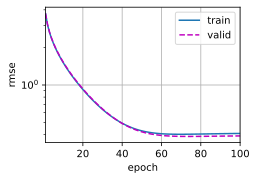

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_ls, valid_ls = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)